# Проект: Разпознаване на пътни знаци

Разпознаването на пътни знаци е критичен компонент от множество системи за умен контрол на пътния трафик, както и в областта на автономното управление на автомобили. Целта на проекта е разработката на конволюционна дълбока невронна мрежа, способна с висока точност да разпознава и класифицира в 43 категории различни видове знаци, независимо от външни фактори като променливи нива на осветяването, разнообразни атмосферни условия и различни ъгли на заснемане. Имплементирана е с помощта на TensorFlow, Keras библиотеките.

## Зареждане изображения за обучение и тестване 

Google Drive адрес на данните: https://drive.google.com/file/d/1yXHeAlH3rvlNEGe4gm1HWBwKn_PMjJ3-/view?usp=sharing 

Обучението на модела се извършва върху база със свободен достъп с 26 640 снимки на различни пътни знаци, групирани в 43 различни категории. За всеки вид съществува множество от изображения с различно качество и резолюция, заснети в различни атмосферни условия, под различен ъгъл, на различни места и с варираща осветеност/време от деня. 

Дефинираме функцията load_data, която зарежда данните от посочената директория 'data_dir'. За всяка категория е създадена отделна поддиректория в 'data_dir', чието име е името на категорията. Те започват от 0 до NUM_CATEGORIES - 1. Във всяка поддиректория има множество изображения. След извличане на данните от файловата система връщаме tuple (images, labels), където images е списък с всички изображения, които ще се използват за обучението на невронната мрежа, а labels е списък с отговарящите им етикети (името на поддиректорията, от която са извлечени). Изображенията идват в различни размери, затова ги преоразмеряваме според константите IMG_WIDTH и IMG_HEIGHT. 

Създаваме и функция sample_random_images, която извежда n на брой случайни изображения от посочена директория, които завършват с '.ppm', с цел визуализация на данните.

In [1]:
# -*- coding: utf-8 -*-

In [1]:
import cv2
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 10
IMG_WIDTH = 30
IMG_HEIGHT = 30
NUM_CATEGORIES = 43
TEST_SIZE = 0.4

def load_data(data_dir):
    images = []
    labels = []

    for folder in os.listdir(data_dir):
        for file in os.listdir(os.path.join(data_dir, folder)):
            img = cv2.imread(os.path.join(data_dir, folder, file))
            res_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(res_img)
            labels.append(folder)

    return (images, labels)

def sample_random_images(directory, num_images=5):
    files = os.listdir(directory)
    
    image_files = [file for file in files if file.lower().endswith('.ppm')]

    random.shuffle(image_files)

    selected_images = image_files[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        image_path = os.path.join(directory, selected_images[i])
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(selected_images[i])

    plt.show()

### Преглед на част от данните
Ще разгледаме няколко случайни от 42 различни категории знаци.

Визуализираме изображения, показващи знак за ограничение на скоростта до 30 км/ч.

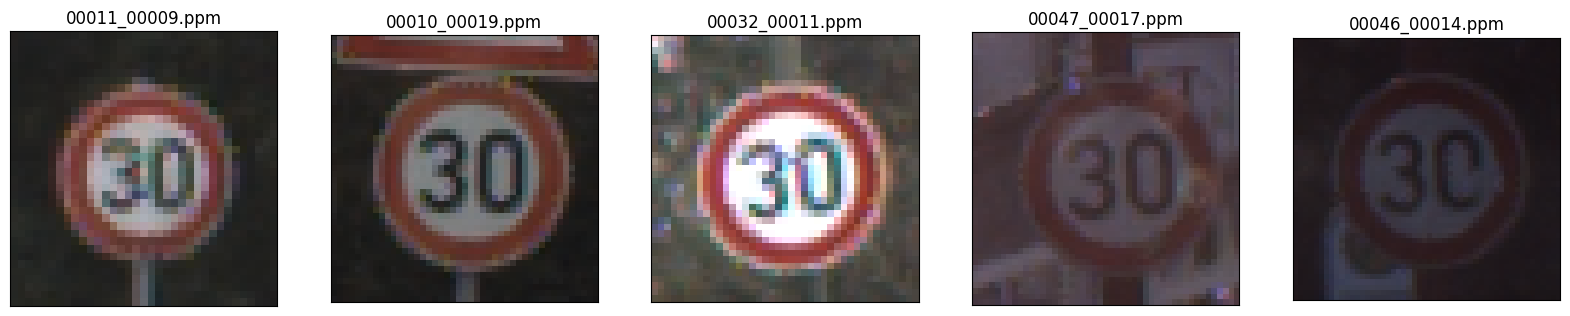

In [26]:
sample_random_images('Data/1')

Визуализираме изображения, показващи знак "Забранено изпреварването".

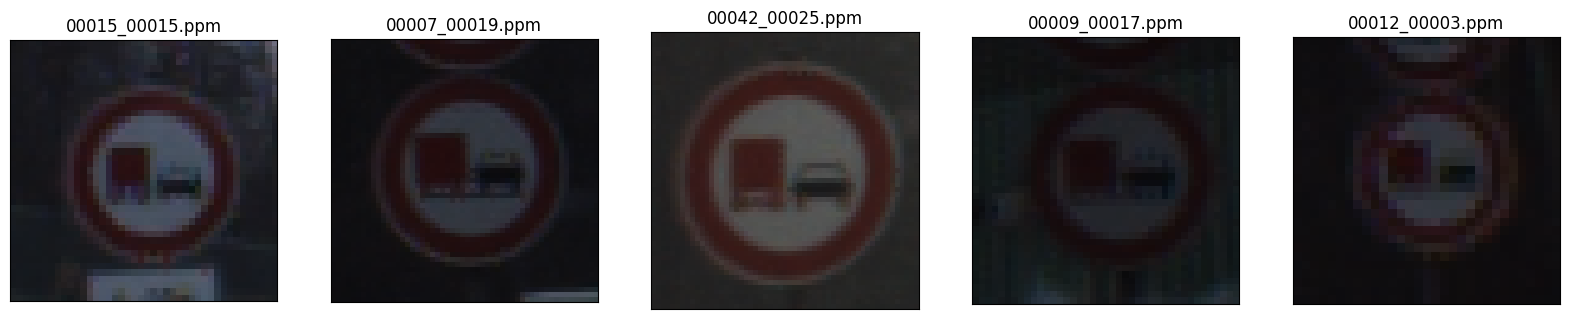

In [14]:
sample_random_images('Data/10')

Визуализираме изображения, показващи знак "Внимание, остър завой".

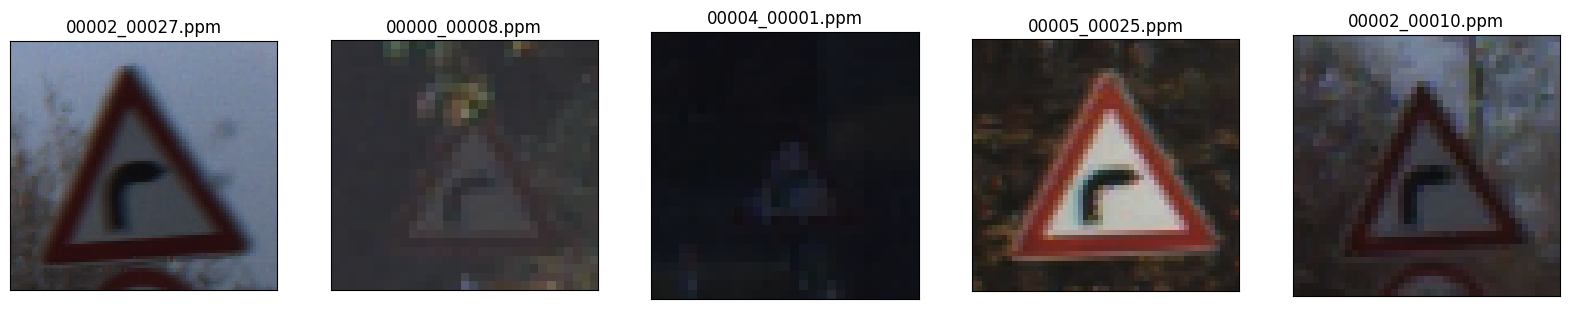

In [16]:
sample_random_images('Data/20')

Визуализираме изображения, показващи знак "Внимание, снежна покривка".

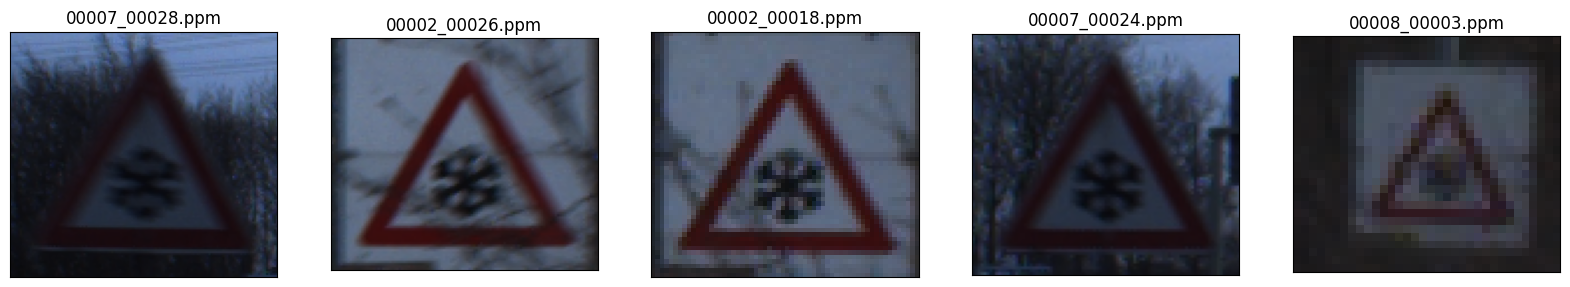

In [19]:
sample_random_images('Data/30')

Визуализираме изображения, показващи знак за кръгово.

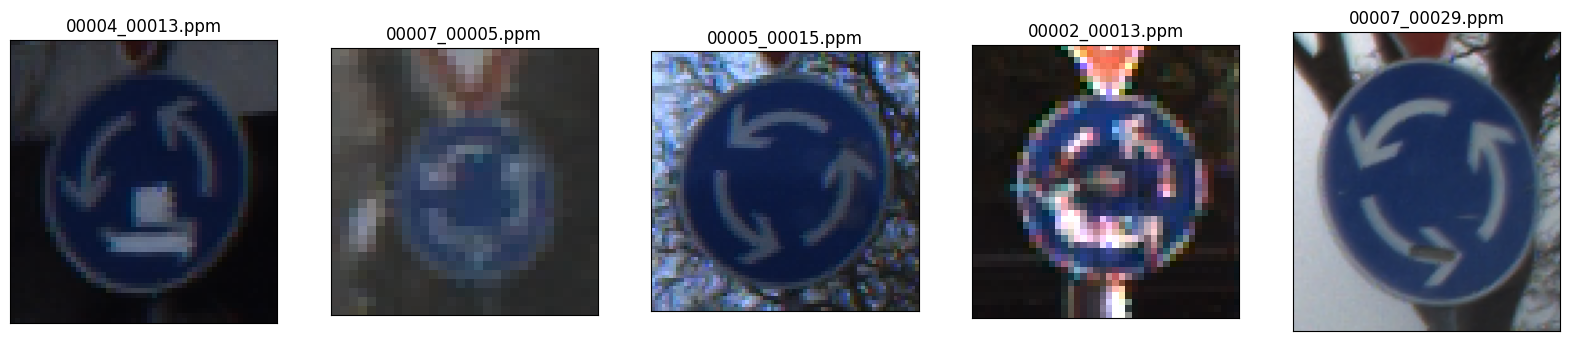

In [20]:
sample_random_images('Data/40')

Визуализираме изображения, показващи знак "Пропусни движещите се по пътя с предимство".

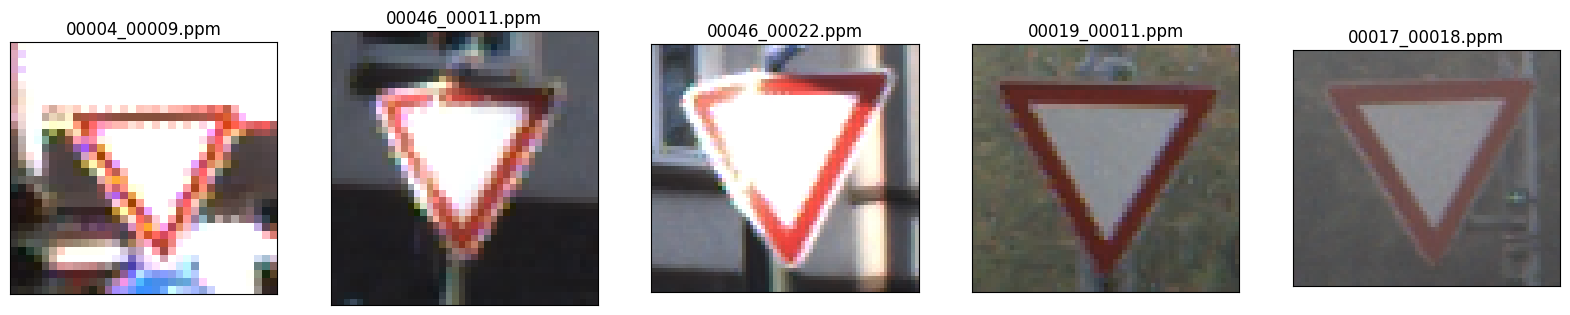

In [24]:
sample_random_images('Data/13')

Използваме load_data за да заредим снимките и съответстващите им етикети, след което ги разделяме на тренировъчни (x_train, y_train) и тестови (x_test, y_test). 

In [2]:
data_dir = 'Data'

images, labels = load_data(data_dir)

labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(np.array(images), np.array(labels), test_size=TEST_SIZE)

## Създаване и трениране на CNN

Чрез функция get_model създаваме и компилираме Deep Convolutional Neural Network модел с два  конволюционни слоя (32 филтъра и kernel 3x3), две прилагания на MaxPooling (за смачкване на изображенията, с цел по-лесно трениране) и два скрити слоя (със съответно 172 и 86 параметъра).

За да избегнем Overfitting и прекалена зависимост от конкретни неврони прилагаме Dropout техника, премахвайки случайни 30% от невроните в мрежата при всяка тренировъчна итерация.

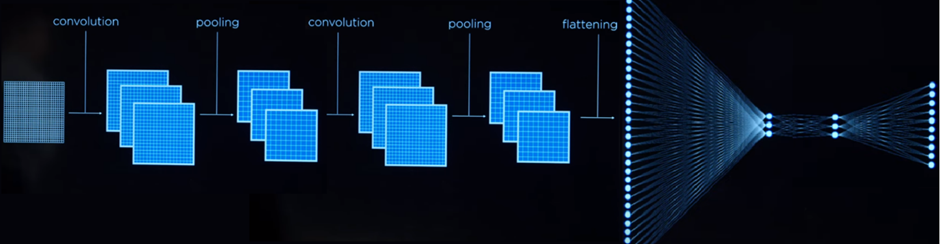

In [3]:
def get_model():
    # Създаване на последователен модел чрез TensorFlow Keras
    model = tf.keras.models.Sequential([
        # Конволюционен слой с 32 филтъра и kernel 3x3 
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_WIDTH, 3)),

        # Max-Pooling с цел смачкване на изображението за по-лесно трениране на модела
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

        # Втори конволюционен слой с 32 филтъра и kernel 3x3 
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_WIDTH, 3)),

        # Втори Max-Pooling с цел смачкване на изображението за по-лесно трениране на модела
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

        # Flattening с цел представяне на данните за отделните пиксели като едноизмерна структура от данни (Input Layer)
        tf.keras.layers.Flatten(),

        # Hidden layer с 172 неврона
        tf.keras.layers.Dense(172, activation="relu"),

        # Втори Hidden layer с 86 неврона
        tf.keras.layers.Dense(86, activation="relu"),

        # Прилагане на Dropout техника за избягване на overfitting, при която при всяка тренировка на мрежата изкючваме случайни 30% от невроните 
        tf.keras.layers.Dropout(0.3),

        # Output layer с по 1 неврон за всяка една от възможните категории
        tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
    ])

    # Компилиране на модела
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = get_model()
model.summary(line_length=80)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d (Conv2D)                    (None, 28, 28, 32)              896         
                                                                                
 max_pooling2d (MaxPooling2D)       (None, 14, 14, 32)              0           
                                                                                
 conv2d_1 (Conv2D)                  (None, 12, 12, 32)              9248        
                                                                                
 max_pooling2d_1 (MaxPooling2D)     (None, 6, 6, 32)                0           
                                                                                
 flatten (Flatten)                  (None, 1152)                    0           
                                                                                
 dense (

Трениране на модела чрез извикване на [`fit`](https://keras.io/api/models/model_training_apis/#fit-method).

In [4]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=EPOCHS)

model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/10
1599/1599 [==============================] - 10s 6ms/step - loss: 2.3186 - accuracy: 0.3965 - val_loss: 1.2919 - val_accuracy: 0.6166
Epoch 2/10
1599/1599 [==============================] - 9s 6ms/step - loss: 1.0214 - accuracy: 0.6932 - val_loss: 0.5530 - val_accuracy: 0.8364
Epoch 3/10
1599/1599 [==============================] - 10s 6ms/step - loss: 0.6244 - accuracy: 0.8126 - val_loss: 0.4099 - val_accuracy: 0.8789
Epoch 4/10
1599/1599 [==============================] - 10s 6ms/step - loss: 0.4958 - accuracy: 0.8585 - val_loss: 0.3277 - val_accuracy: 0.9052
Epoch 5/10
1599/1599 [==============================] - 10s 6ms/step - loss: 0.4060 - accuracy: 0.8838 - val_loss: 0.3200 - val_accuracy: 0.9151
Epoch 6/10
1599/1599 [==============================] - 10s 6ms/step - loss: 0.3753 - accuracy: 0.8997 - val_loss: 0.3280 - val_accuracy: 0.9163
Epoch 7/10
1599/1599 [==============================] - 10s 6ms/step - loss: 0.3448 - accuracy: 0.9063 - val_loss: 1.3041 - val_acc

[0.2958178222179413, 0.9398460984230042]

Изчертаваме точността на обучение и точността на валидиране, използвайки matplotlib, за да направим оценка на модела.

[]

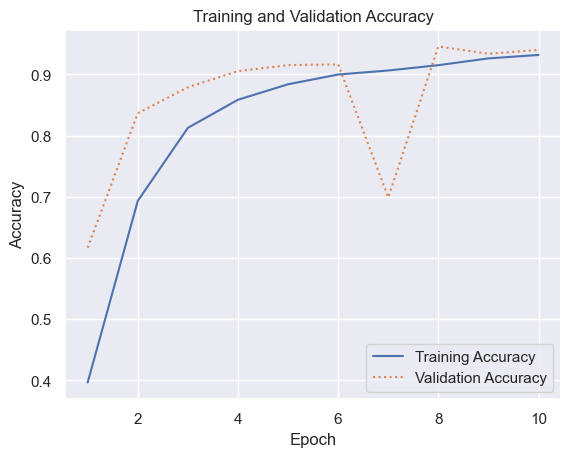

In [5]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Тестване с конкретни примери

Зареждаме в списък sign_meaning значението на всяка една категория знаци с цел тестване на системата.

In [12]:
sign_meaning = [
    "Скоростово ограничение до 20 км/ч",
    "Скоростово ограничение до 30 км/ч",
    "Скоростово ограничение до 50 км/ч",
    "Скоростово ограничение до 60 км/ч",
    "Скоростово ограничение до 70 км/ч",
    "Скоростово ограничение до 80 км/ч",
    "Край на скоростово ограничение до 80 км/ч",
    "Скоростово ограничение до 100 км/ч",
    "Скоростово ограничение до 120 км/ч",
    "Забранено изпреварването",
    "Забранено на товарни МПС да изпреварват",
    "Кръстовище с път без предимство",
    "Път с предимство",
    "Пропусни движещите се по пътя с предимство",
    "Спри! Пропусни движещите се по пътя с предимство",
    "Забранено е влизането на пътни превозни средства в двете посоки",
    "Забранено е влизането на товарни автомобили",
    "Забранено е влизането на пътни превозни средства",
    "Внимание! Други опасности",
    "Опасен завой наляво",
    "Опасен завой надясно",
    "Последователни опасни завои, първият от които е наляво",
    "Неравности по платното за движение",
    "Опасност от хлъзгане",
    "Платно за движение, стеснено отдясно",
    "Участък от пътя в ремонт",
    "Светофар",
    "Внимание! Пешеходци",
    "Внимание! Деца",
    "Внимание! Велосипедисти",
    "Внимание! Сняг",
    "Възможна е поява на диви животни",
    "Край на въведената с пътен знак забрана за движение със скорост, по-висока от означената",
    "Движение само надясно след знака",
    "Движение само наляво след знака",
    "Движение само направо след знака",
    "Движение само направо или надясно след знака",
    "Движение само направо или наляво след знака",
    "Преминаване отдясно на знака",
    "Преминаване отляво на знака",
    "Кръгово движение",
    "Край на въведената с пътен знак забрана за изпреварване на моторни превозни средства",
    "Край на въведената с пътен знак забрана за изпреварване от товарни автомобили с максимално допустима маса над 3,5 тона на моторни превозни средства"
]

Дефинираме функция, чрез която да тестваме модела върху отделни изображения.

In [30]:
def test_image(index):
    img = images [index]
    res_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    input_image = np.expand_dims(res_img, axis=0)
    
    predictions = model.predict(input_image)
    predicted_category = np.argmax(predictions)
    
    rgb_img = cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    
    print(f"Предполагаемо значение: {predicted_category} - {sign_meaning[predicted_category]}")
    if (predicted_category == np.argmax(labels[index])):
        print("Правилно предположение!")
    else:
        print("Грешно предположение!")
        ans = np.argmax(labels[index])
        print(f"Правилната категория е: {ans} - {sign_meaning[ans]}")
    

### Пример 1: Знак "Скоростово ограничение до 20 км/ч"

1/1 [==============================] - 0s 16ms/step
Предполагаемо значение: 0 - Скоростово ограничение до 20 км/ч
Правилно предположение!


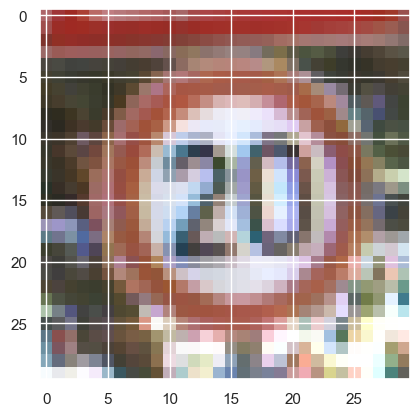

In [28]:
test_image(50)

### Пример 2: Знак "Пропусни движещите се по пътя с предимство"

1/1 [==============================] - 0s 17ms/step
Предполагаемо значение: 13 - Пропусни движещите се по пътя с предимство
Правилно предположение!


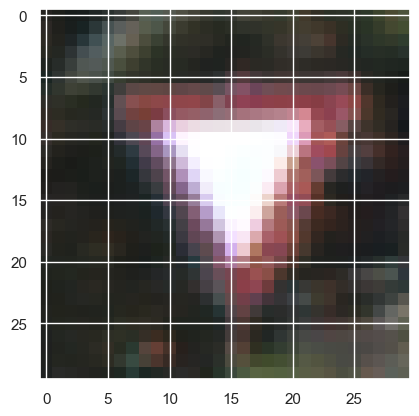

In [39]:
test_image(6210)

### Пример 3: Знак "Забранено изпреварването"

1/1 [==============================] - 0s 18ms/step
Предполагаемо значение: 9 - Забранено изпреварването
Правилно предположение!


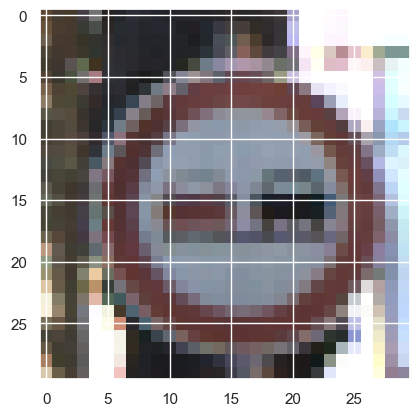

In [42]:
test_image(26000)

### Пример 4: Знак "Внимание! Пешеходци"

1/1 [==============================] - 0s 15ms/step
Предполагаемо значение: 27 - Внимание! Пешеходци
Правилно предположение!


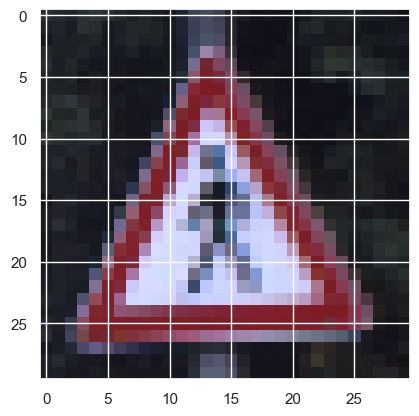

In [48]:
test_image(14005)

### Пример 5: Знак "Спри! Пропусни движещите се по пътя с предимство"

1/1 [==============================] - 0s 17ms/step
Предполагаемо значение: 14 - Спри! Пропусни движещите се по пътя с предимство
Правилно предположение!


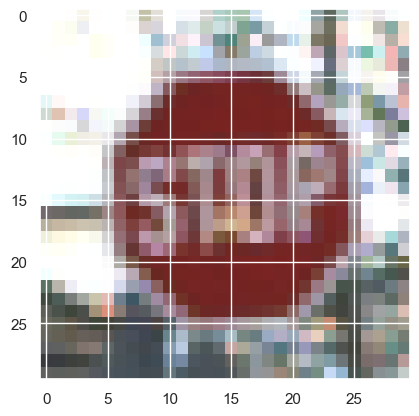

In [52]:
test_image(7005)

### Пример 6: Знак "Път с предимство"

1/1 [==============================] - 0s 17ms/step
Предполагаемо значение: 12 - Път с предимство
Правилно предположение!


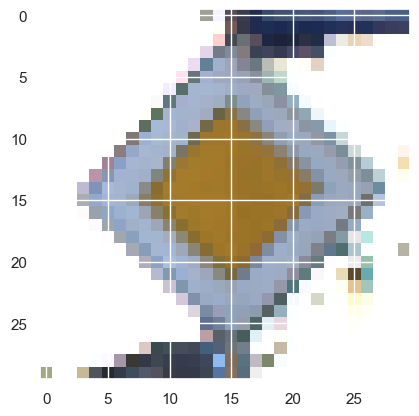

In [54]:
test_image(5005)